In [5]:
import gymnasium as gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
def fit_lane_lines(lines, img):
    left_x, left_y = [], []
    right_x, right_y = [], []

    height, width, _ = img.shape
    img_center = width // 2

    if lines is None:
        return None, None

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)  # avoid division by zero

        if abs(slope) < 0.5:
            continue  # filter out nearly-horizontal lines

        if slope < 0 and x1 < img_center and x2 < img_center:
            left_x += [x1, x2]
            left_y += [y1, y2]
        elif slope > 0 and x1 > img_center and x2 > img_center:
            right_x += [x1, x2]
            right_y += [y1, y2]

    left_fit = np.polyfit(left_y, left_x, 1) if len(left_x) > 0 else None
    right_fit = np.polyfit(right_y, right_x, 1) if len(right_x) > 0 else None

    return left_fit, right_fit


In [7]:
def calculate_steering_from_center(left_fit, right_fit, img_width, img_height):
    if left_fit is None or right_fit is None:
        return 0.0  # fail-safe: go straight

    y = img_height - 1  # bottom of the image

    left_x = left_fit[0] * y + left_fit[1]
    right_x = right_fit[0] * y + right_fit[1]
    lane_center = (left_x + right_x) / 2.0

    # Car center
    car_center = img_width / 2.0

    offset = lane_center - car_center

    # Normalize and clamp steering
    steering = np.clip(offset / (img_width / 2), -1.0, 1.0)
    return steering


In [8]:
for _ in range(300):
    img = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(img, 50, 150)

    height, width = edges.shape
    mask = np.zeros_like(edges)
    mask[int(height/2):, :] = 255
    roi_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=20)

    # Fit lane lines
    left_fit, right_fit = fit_lane_lines(lines, obs)

    # Calculate steering from lane center
    steering = calculate_steering_from_center(left_fit, right_fit, width, height)

    # Action: steer, gas, brake
    action = np.array([steering, 1.0, 0.0])
    obs, reward, done, truncated, info = env.step(action)

    # Visualization
    line_img = obs.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw lane fits
    y_vals = np.linspace(int(height/2), height - 1, 20, dtype=np.int32)
    for fit, color in zip([left_fit, right_fit], [(255, 0, 0), (0, 0, 255)]):
        if fit is not None:
            for y in y_vals:
                x = int(fit[0] * y + fit[1])
                cv2.circle(line_img, (x, y), 3, color, -1)

    cv2.imshow("Lane Following", line_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()


NameError: name 'obs' is not defined

In [9]:
env = gym.make("CarRacing-v3",max_episode_steps=1)  # 'rgb_array' for image-only
obs = env.reset()[0]


for _ in range(200):
    # Convert to grayscale
    img = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)

    # Edge detection
    edges = cv2.Canny(img, 50, 150)

    # Region of interest (lower half)
    mask = np.zeros_like(edges)
    height, width = edges.shape
    mask[int(height/2):, :] = 255
    roi_edges = cv2.bitwise_and(edges, mask)

    # Hough line detection
    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=20)

    # Steering based on lines
    steering = calculate_steering_angle(lines, width)
    action = np.array([steering, 1.0, 0.0])  # steer, gas, brake

    # Take action
    obs, reward, done, truncated, info = env.step(action)

    # Optionally show frame with lines
    line_img = obs.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.imshow("Lane Detection", line_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()


NameError: name 'calculate_steering_angle' is not defined

(96, 96)


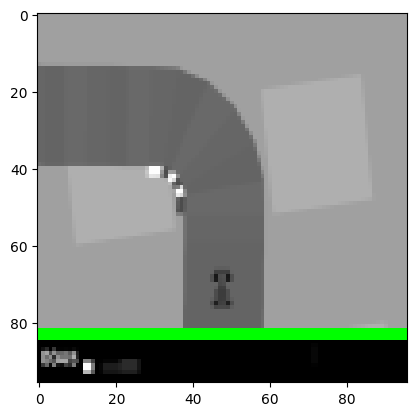

In [10]:
env = gym.make("CarRacing-v3",max_episode_steps=1)  # 'rgb_array' for image-only
obs = env.reset()[0]

for _ in range(70):
    action = np.array([0.0, 1.0, 0.0])
    obs, reward, done, truncated, info = env.step(action)

# Converting to grayscale
img = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
# img_bgr = cv2.cvtColor(obs,cv2.COLOR_BGR2GRAY)

# Applying Canny edge detection
edges = cv2.Canny(img,threshold1=10,threshold2=100)

# print(img.shape)

print(edges.shape)

height,width = edges.shape

mask = np.zeros_like(edges)

mask[int(height/2):,:] = 255

# lower half
roi_edges = cv2.bitwise_and(edges,mask)

# find lines
lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=20)
line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(line_img)
plt.show()


# plt.figure(figsize=(10, 10)) 

# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(obs)

# plt.subplot(1, 2, 2)
# plt.title("Modified")
# plt.imshow(roi_edges, cmap='gray')

# plt.show()


In [11]:
def calculate_steering_angle(lines, img_width):
    if lines is None:
        return 0.0  # go straight if no lines

    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            continue  # skip vertical lines
        angle = np.arctan2(dy, dx)
        angles.append(angle)

    if len(angles) == 0:
        return 0.0

    average_angle = np.mean(angles)

    # Normalize steering angle (this part is heuristic!)
    steering = np.clip(-average_angle / np.pi, -1.0, 1.0)
    return steering


### Let’s improve the lane detection by fitting curves (e.g., 2nd-degree polynomials) instead of just straight lines. This allows the car to handle curves on the track better.

**Why Fit Curves?**

- Straight lines (np.polyfit(..., deg=1)) work for straight roads.

- Curved tracks need quadratic fits (deg=2) to model lane lines more accurately.

**We'll:**
- Detect line segments from the Hough Transform.

- Separate them into left/right based on slope and position.

- Fit 2nd-degree polynomials (curves) to each side.

- Estimate the lane center at the bottom of the image.

- Steer toward the center using a proportional controller.

1. Fit Left & Right Curves

In [12]:
def fit_lane_curves(lines, img):
    left_x, left_y = [], []
    right_x, right_y = [], []

    height, width, _ = img.shape
    center_x = width / 2

    if lines is None:
        return None, None

    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1

        if dx == 0 or abs(dy / dx) < 0.3:
            continue  # skip vertical or nearly-horizontal lines

        slope = dy / dx

        if slope < 0 and x1 < center_x and x2 < center_x:
            left_x += [x1, x2]
            left_y += [y1, y2]
        elif slope > 0 and x1 > center_x and x2 > center_x:
            right_x += [x1, x2]
            right_y += [y1, y2]

    left_fit = np.polyfit(left_y, left_x, 2) if len(left_x) >= 6 else None
    right_fit = np.polyfit(right_y, right_x, 2) if len(right_x) >= 6 else None

    return left_fit, right_fit


2. Estimate Lane Center from Curve Fit

In [13]:
def get_lane_center_offset_from_curve(left_fit, right_fit, img_width, img_height):
    y = img_height - 1  # bottom of image

    if left_fit is None or right_fit is None:
        return 0.0

    left_x = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    right_x = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]

    lane_center = (left_x + right_x) / 2
    car_center = img_width / 2
    offset = lane_center - car_center

    # Normalize offset for steering [-1, 1]
    steering = np.clip(offset / (img_width / 2), -1.0, 1.0)
    return steering


3. Curve Fitting

In [14]:
for _ in range(300):
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    height, width = edges.shape
    mask = np.zeros_like(edges)
    mask[int(height / 2):, :] = 255
    roi_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=20)

    # Fit curves
    left_fit, right_fit = fit_lane_curves(lines, obs)

    # Calculate steering
    steering = get_lane_center_offset_from_curve(left_fit, right_fit, width, height)
    action = np.array([steering, 1.0, 0.0])
    obs, reward, done, truncated, info = env.step(action)

    # Visualization
    vis = obs.copy()
    y_vals = np.linspace(int(height / 2), height - 1, 50, dtype=np.int32)
    for fit, color in zip([left_fit, right_fit], [(255, 0, 0), (0, 255, 0)]):
        if fit is not None:
            for y in y_vals:
                x = int(fit[0] * y**2 + fit[1] * y + fit[2])
                cv2.circle(vis, (x, y), 2, color, -1)

    cv2.imshow("Curve Fitted Lane Following", vis)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
